In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install --upgrade ipykernel

In [ ]:
pip install folium

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from sklearn.model_selection import KFold
from transformers import set_seed, GPT2Config, GPT2Tokenizer, GPT2ForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding



In [ ]:
path ="/content/drive/MyDrive/GPT2_Kcr/data/"
result_path ="/content/drive/MyDrive/GPT2_Kcr/Model/"


In [ ]:
class ProteinDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)
# Sử dụng BertTokenizer để token hóa dữ liệu
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

In [ ]:
pip install wandb

In [ ]:
pip install openpyxl

In [ ]:
!pip install --upgrade transformers

Kiểm thử đọc lập trên X_test

In [ ]:
import pandas as pd
# Định nghĩa đường dẫn dữ liệu
test_path = path + 'test_data.csv'
# Hàm chuyển đổi chuỗi thành K-mer
def k_mer_sentence(sequence, k):
    return " ".join(sequence[i:i + k] for i in range(len(sequence) - k + 1))
# Xử lý dữ liệu test
def process_test_data(test_path, k):
    df_test = pd.read_csv(test_path)
    df_test['n_gram'] = df_test['Sequence'].apply(lambda seq: k_mer_sentence(seq, k))
    X_test, y_test = df_test['n_gram'], df_test['Label']
    return X_test, y_test
# Thực hiện tiền xử lý với n-gram = 1
n = 1
X_test, y_test = process_test_data(test_path, n)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tìm thấy mô hình tốt nhất: /content/drive/MyDrive/GPT2_Bert_Kcr/Model/2.7.Model_CL_GPT2_Kcr.pth

 Classification Report:
              precision    recall  f1-score   support

     Class 0       0.87      0.78      0.82      2989
     Class 1       0.80      0.88      0.84      2989

    accuracy                           0.83      5978
   macro avg       0.83      0.83      0.83      5978
weighted avg       0.83      0.83      0.83      5978



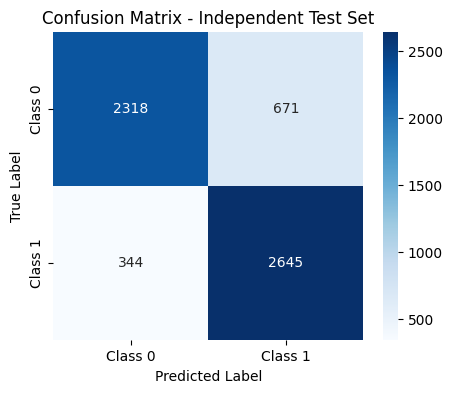

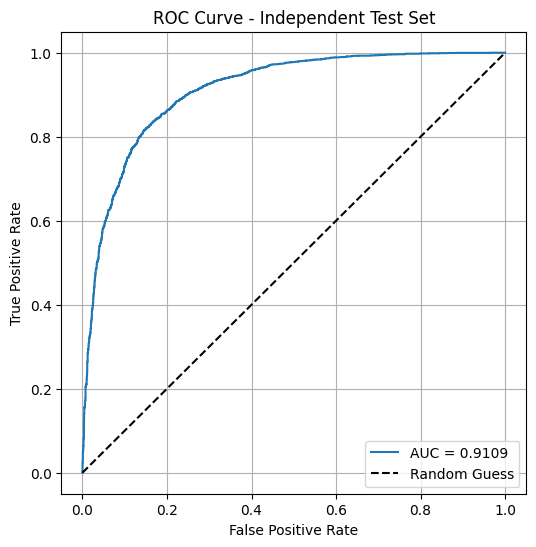


 Kết quả Independent Test đã được lưu vào /content/drive/MyDrive/GPT2_Bert_Kcr/Model/2.7.Independent_Test_CL_GPT2_Kcr.xlsx


In [ ]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from transformers import set_seed, GPT2Config, GPT2Tokenizer, GPT2ForSequenceClassification

# Đặt seed để tái tạo kết quả
set_seed(731)  # My Birthday!

# Cấu hình mô hình GPT-2 cho bài toán phân loại nhị phân
model_config = GPT2Config.from_pretrained('gpt2', num_labels=2)
model = GPT2ForSequenceClassification.from_pretrained('gpt2', config=model_config)

# Cấu hình tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.padding_side = "left"  # Rất quan trọng cho GPT-2
tokenizer.pad_token = tokenizer.eos_token

# Điều chỉnh kích thước embeddings
model.resize_token_embeddings(len(tokenizer))
model.config.pad_token_id = model.config.eos_token_id

# Tìm mô hình có AUC cao nhất đã lưu
best_model_path = None
for file in os.listdir(result_path):
    if file.startswith("CLGPT_Kcr") and file.endswith(".pth"):
        best_model_path = os.path.join(result_path, file)
        print(f"Tìm thấy mô hình tốt nhất: {best_model_path}")
        break

if best_model_path is None:
    raise FileNotFoundError("Không tìm thấy mô hình tốt nhất trong result_path!")

# Load mô hình đã lưu
model.load_state_dict(torch.load(best_model_path, map_location=torch.device('cpu')))
model.eval()

# Chuẩn bị dữ liệu test
independent_data = X_test.tolist()
independent_labels = y_test.tolist()

# Tokenize dữ liệu
test_encodings = tokenizer(independent_data, truncation=True, padding=True, max_length=512, return_tensors="pt")

# Dự đoán
with torch.no_grad():
    outputs = model(**test_encodings)
    probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
    preds = probabilities.argmax(dim=-1).numpy()
    probas = probabilities[:, 1].numpy()  # Xác suất lớp 1

# Tính confusion matrix
conf_matrix = confusion_matrix(independent_labels, preds)
TN, FP, FN, TP = conf_matrix.ravel()

# Tính AUC
fpr, tpr, _ = roc_curve(independent_labels, probas)
auc_score = auc(fpr, tpr)

# In báo cáo phân loại
print("\n Classification Report:")
print(classification_report(independent_labels, preds, target_names=['Class 0', 'Class 1']))

# Lưu kết quả vào file Excel
results = pd.DataFrame([{'TP': TP, 'FP': FP, 'TN': TN, 'FN': FN, 'AUC': auc_score}])
output_file = os.path.join(result_path, '2.7.Independent_Test_CL_GPT2_Kcr.xlsx')
results.to_excel(output_file, index=False)

# Vẽ Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Independent Test Set")
plt.show()

# Vẽ đường cong ROC
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Independent Test Set')
plt.legend()
plt.grid()
plt.show()

print(f"\n Kết quả Independent Test đã được lưu vào {output_file}")


In [ ]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from transformers import set_seed, GPT2Config, GPT2Tokenizer, GPT2ForSequenceClassification
# Đặt seed để tái tạo kết quả
set_seed(731)  # My Birthday!

# Cấu hình mô hình GPT-2 cho bài toán phân loại nhị phân
model_config = GPT2Config.from_pretrained('gpt2', num_labels=2)
model = GPT2ForSequenceClassification.from_pretrained('gpt2', config=model_config)

# Cấu hình tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.padding_side = "left"  # Rất quan trọng cho GPT-2
tokenizer.pad_token = tokenizer.eos_token

# Điều chỉnh kích thước embeddings
model.resize_token_embeddings(len(tokenizer))
model.config.pad_token_id = model.config.eos_token_id
# Tìm mô hình có AUC cao nhất đã lưu
best_model_path = None
for file in os.listdir(result_path):
    if file.startswith("CLGPT_Kcr") and file.endswith(".pth"):
        best_model_path = os.path.join(result_path, file)
        print(f"Tìm thấy mô hình tốt nhất: {best_model_path}")
        break

if best_model_path is None:
    raise FileNotFoundError("Không tìm thấy mô hình tốt nhất trong result_path!")

# Load mô hình đã lưu
model.load_state_dict(torch.load(best_model_path, map_location=torch.device('cpu')))
print(model)

In [ ]:
print(model)

GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (score): Linear(in_features=768, out_features=2, bias=False)
)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tìm thấy mô hình tốt nhất: /content/drive/MyDrive/GPT2_Bert_Kcr/Model/2.7.Model_CL_GPT2_Kcr.pth


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


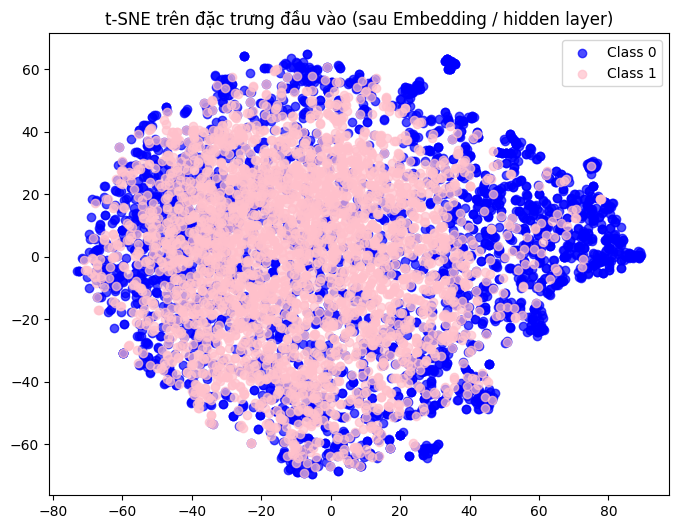

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


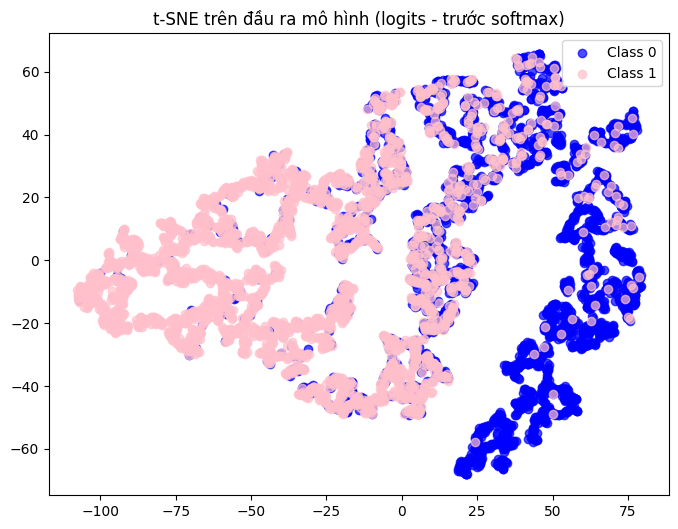

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch
import os
from transformers import set_seed, GPT2Config, GPT2Tokenizer, GPT2ForSequenceClassification

# Đặt seed để tái tạo kết quả
set_seed(731)

# === Chuẩn bị dữ liệu ===
data = X_test.tolist()
labels = y_test.tolist()

# Load tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"

# Token hóa dữ liệu
data_encodings = tokenizer(data, truncation=True, padding=True, max_length=512, return_tensors="pt")

X_vis = data_encodings
y_vis = np.array(labels)

# === Load mô hình GPT-2 đã fine-tune ===
model_config = GPT2Config.from_pretrained('gpt2', num_labels=2)
model = GPT2ForSequenceClassification.from_pretrained('gpt2', config=model_config)
model.resize_token_embeddings(len(tokenizer))
model.config.pad_token_id = model.config.eos_token_id
model.config.output_hidden_states = True  # Kích hoạt để lấy hidden_states

# Load mô hình đã huấn luyện
best_model_path = None
for file in os.listdir(result_path):
    if file.startswith("CLGPT_Kcr") and file.endswith(".pth"):
        best_model_path = os.path.join(result_path, file)
        print(f"Tìm thấy mô hình tốt nhất: {best_model_path}")
        break

if best_model_path is None:
    raise FileNotFoundError("Không tìm thấy mô hình tốt nhất trong result_path!")

model.load_state_dict(torch.load(best_model_path, map_location=torch.device('cpu')))
model.eval()

# === Tính toán đặc trưng đầu vào và đầu ra ===
layer_input = 1  # Layer sau Embedding

with torch.no_grad():
    outputs = model(**X_vis)
    hidden_states = outputs.hidden_states
    logits = outputs.logits

# === 1. Trực quan hóa đặc trưng đầu vào (sau Embedding hoặc hidden layer) ===
features_input = torch.mean(hidden_states[layer_input], dim=1).cpu().numpy()

features_input_2d = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42).fit_transform(features_input)

colors = ['blue', 'pink']
plt.figure(figsize=(8, 6))
for label in np.unique(y_vis):
    idx = y_vis == label
    plt.scatter(features_input_2d[idx, 0], features_input_2d[idx, 1],
                label=f"Class {label}", alpha=0.7, color=colors[label % len(colors)])
plt.title("t-SNE trên đặc trưng đầu vào (sau Embedding / hidden layer)")
plt.legend()
plt.show()

# === 2. Trực quan hóa đặc trưng đầu ra (logits - trước softmax) ===
features_output = logits.cpu().numpy()
features_output_2d = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42).fit_transform(features_output)

plt.figure(figsize=(8, 6))
for label in np.unique(y_vis):
    idx = y_vis == label
    plt.scatter(features_output_2d[idx, 0], features_output_2d[idx, 1],
                label=f"Class {label}", alpha=0.7, color=colors[label % len(colors)])
plt.title("t-SNE trên đầu ra mô hình (logits - trước softmax)")
plt.legend()
plt.show()
